#  Color Classification


## Predicting color R,G,B values from names.

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 43kB/s 
    100% |████████████████████████████████| 3.0MB 7.1MB/s 
    100% |████████████████████████████████| 419kB 11.3MB/s 
    100% |████████████████████████████████| 61kB 23.2MB/s 


In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split

In [0]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  323k  100  323k    0     0  1260k      0 --:--:-- --:--:-- --:--:-- 1260k
name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


In [0]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), float(row[1]) / 255.0, float(row[2]) / 255.0, float(row[3]) / 255.0
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 0.6823529411764706, 0.7137254901960784, 0.3411764705882353)


In [0]:
# collecting x features
names = [item[0] for item in colors_rgb]

# collecting target list
r = [item[1] for item in colors_rgb]
g = [item[2] for item in colors_rgb]
b = [item[3] for item in colors_rgb]
targets = np.column_stack([r, g, b])

In [0]:
# using train/test split just for fun
names_train, names_test, targets_train, targets_test = train_test_split(names, targets, test_size = 0.1, random_state = 42)

In [0]:
maxlen = 25
t = Tokenizer(char_level=True)

# fitting only on the train
t.fit_on_texts(names_train)

# transofrming train dataset
tokenized_train = t.texts_to_sequences(names_train)
padded_names_train = pad_sequences(tokenized_train, maxlen=maxlen)
padded_names_train = padded_names_train.astype('float32')

# transforming test dataset
tokenized_test = t.texts_to_sequences(names_test)
padded_names_test = pad_sequences(tokenized_test, maxlen=maxlen)
padded_names_test = padded_names_test.astype('float32')

vocab_size = len(t.word_index) + 1

** For the purpose of this task, I deiced to test both a general DNN model as well as an RNN model to see which one would yield better color recognition results. I will start by testing the RNN model. **

In [0]:
# Improved model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
model.add(tf.keras.layers.GRU(128, return_sequences=True))
model.add(tf.keras.layers.GRU(128))
model.add(tf.keras.layers.Dense(516, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile('rmsprop', loss='mse') # changed optimizer to rmsprop
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 1, 25)             0         
_________________________________________________________________
unified_gru_10 (UnifiedGRU)  (None, 1, 128)            59520     
_________________________________________________________________
unified_gru_11 (UnifiedGRU)  (None, 128)               99072     
_________________________________________________________________
dense_30 (Dense)             (None, 516)               66564     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                33088     
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 195       
Total params: 258,439
Trainable params: 258,439
Non-trainable params: 0
_______________________________________________

In [0]:
history = model.fit(padded_names_train, targets_train, epochs=10, validation_split=0.1)

Train on 11466 samples, validate on 1275 samples
Epoch 1/10
11466/11466 [==============================] - 5s 393us/sample - loss: 0.0633 - val_loss: 0.0593
Epoch 2/10
11466/11466 [==============================] - 3s 297us/sample - loss: 0.0601 - val_loss: 0.0577
Epoch 3/10
11466/11466 [==============================] - 4s 306us/sample - loss: 0.0581 - val_loss: 0.0564
Epoch 4/10
11466/11466 [==============================] - 3s 300us/sample - loss: 0.0564 - val_loss: 0.0568
Epoch 5/10
11466/11466 [==============================] - 4s 313us/sample - loss: 0.0549 - val_loss: 0.0566
Epoch 6/10
11466/11466 [==============================] - 3s 294us/sample - loss: 0.0534 - val_loss: 0.0551
Epoch 7/10
11466/11466 [==============================] - 3s 287us/sample - loss: 0.0517 - val_loss: 0.0561
Epoch 8/10
11466/11466 [==============================] - 3s 286us/sample - loss: 0.0505 - val_loss: 0.0554
Epoch 9/10
11466/11466 [==============================] - 3s 274us/sample - loss: 0.048

** Next, I will set up a regular dense DNN model to evaluate its performance as well.**

In [0]:
model_dnn = tf.keras.Sequential()
model_dnn.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
model_dnn.add(tf.keras.layers.Flatten())
model_dnn.add(tf.keras.layers.Dense(516, activation='relu')) # added extra wide layer
model_dnn.add(tf.keras.layers.Dense(262, activation='relu')) # added another layer
model_dnn.add(tf.keras.layers.Dense(112, activation='relu')) # added a third layer
model_dnn.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model_dnn.compile('rmsprop', loss='mse') # changed optimizer to rmsprop
model_dnn.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 1, 25)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 25)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 516)               13416     
_________________________________________________________________
dense_38 (Dense)             (None, 262)               135454    
_________________________________________________________________
dense_39 (Dense)             (None, 112)               29456     
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 339       
Total params: 178,665
Trainable params: 178,665
Non-trainable params: 0
_______________________________________________

In [0]:
history_dnn = model_dnn.fit(padded_names_train, targets_train, epochs=10, validation_split=0.1)

Train on 11466 samples, validate on 1275 samples
Epoch 1/10
11466/11466 [==============================] - 2s 214us/sample - loss: 0.0690 - val_loss: 0.0587
Epoch 2/10
11466/11466 [==============================] - 2s 172us/sample - loss: 0.0618 - val_loss: 0.0607
Epoch 3/10
11466/11466 [==============================] - 2s 171us/sample - loss: 0.0597 - val_loss: 0.0628
Epoch 4/10
11466/11466 [==============================] - 2s 179us/sample - loss: 0.0581 - val_loss: 0.0565
Epoch 5/10
11466/11466 [==============================] - 2s 178us/sample - loss: 0.0565 - val_loss: 0.0578
Epoch 6/10
11466/11466 [==============================] - 2s 177us/sample - loss: 0.0551 - val_loss: 0.0560
Epoch 7/10
11466/11466 [==============================] - 2s 177us/sample - loss: 0.0537 - val_loss: 0.0565
Epoch 8/10
11466/11466 [==============================] - 2s 173us/sample - loss: 0.0522 - val_loss: 0.0550
Epoch 9/10
11466/11466 [==============================] - 2s 173us/sample - loss: 0.050

** Visualizing the two side by side: **

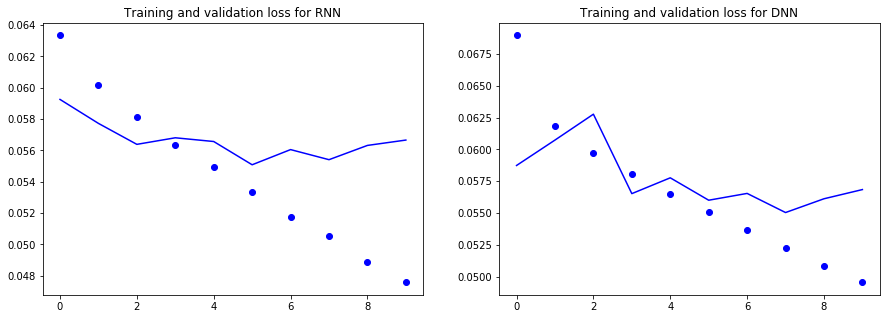

In [0]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
loss_rnn = history.history['loss']
val_loss_rnn = history.history['val_loss']
loss_dnn = history_dnn.history['loss']
val_loss_dnn = history_dnn.history['val_loss']
epochs = range(len(loss))
axes[0].plot(epochs, loss_rnn, 'bo')
axes[0].plot(epochs, val_loss_rnn, 'b')
axes[0].set_title('Training and validation loss for RNN')
axes[1].plot(epochs, loss_dnn, 'bo')
axes[1].plot(epochs, val_loss_dnn, 'b')
axes[1].set_title('Training and validation loss for DNN')
plt.show()

In [0]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [0]:
def scale(n):
    return int(n * 255)

In [0]:
def predict(name, model):
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    padded = padded.astype('float32')
    pred = model.predict(np.array(padded))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

light blue, R,G,B: 122 182 215


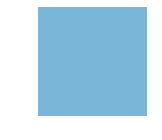

blue, R,G,B: 93 149 177


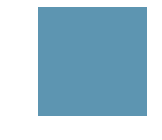

dark blue, R,G,B: 84 104 140


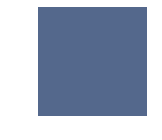

tensorflow orange, R,G,B: 230 144 59


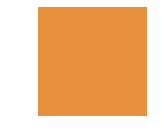

In [0]:
# Seeing good results with RNN
predict("light blue", model)
predict("blue", model)
predict("dark blue", model)
predict("tensorflow orange", model)

** The colors look pretty spot on! **

In [0]:
# just for fun, let us also measure the accuracy
model.evaluate(padded_names_test, targets_test)

1416/1416 [==============================] - 0s 100us/sample - loss: 0.0570


0.05699250051530741

** Actually seeing good performance with the hidden test set as well! Yay! **

light blue, R,G,B: 122 163 187


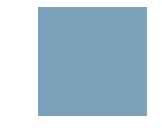

blue, R,G,B: 111 145 152


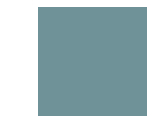

dark blue, R,G,B: 95 104 143


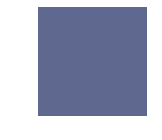

tensorflow orange, R,G,B: 201 123 65


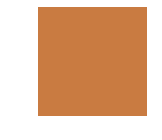

In [0]:
# checking regular DNN
predict("light blue", model_dnn)
predict("blue", model_dnn)
predict("dark blue", model_dnn)
predict("tensorflow orange", model_dnn)

In [0]:
# just for fun, let us also measure the accuracy
model_dnn.evaluate(padded_names_test, targets_test)

1416/1416 [==============================] - 0s 61us/sample - loss: 0.0580


0.057989523361968456

** The colors look ok, but the test performance and visualization is lightly worse here (seeing some green cues being picked up). Looks like RNN wins! **

** Nonetheless, it is important to mention that both models due to their highest degree of complexity still perform better than the given baseline with colors being barely recognizible.**

## Outputting original model as a baseline reference below

In [0]:
# outputting original model as a baseline reference
model_original = tf.keras.Sequential()
model_original.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
model_original.add(tf.keras.layers.Flatten())
model_original.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model_original.compile('adam', loss='mse')

model_original.fit(padded_names_train, targets_train, epochs=10, validation_split=0.1)

Train on 11466 samples, validate on 1275 samples
Epoch 1/10
11466/11466 [==============================] - 1s 54us/sample - loss: 0.2351 - val_loss: 0.1868
Epoch 2/10
11466/11466 [==============================] - 0s 43us/sample - loss: 0.1610 - val_loss: 0.1401
Epoch 3/10
11466/11466 [==============================] - 0s 44us/sample - loss: 0.1228 - val_loss: 0.1005
Epoch 4/10
11466/11466 [==============================] - 0s 42us/sample - loss: 0.1008 - val_loss: 0.0980
Epoch 5/10
11466/11466 [==============================] - 0s 42us/sample - loss: 0.0936 - val_loss: 0.0756
Epoch 6/10
11466/11466 [==============================] - 0s 43us/sample - loss: 0.0681 - val_loss: 0.0627
Epoch 7/10
11466/11466 [==============================] - 0s 42us/sample - loss: 0.0658 - val_loss: 0.0628
Epoch 8/10
11466/11466 [==============================] - 0s 42us/sample - loss: 0.0653 - val_loss: 0.0622
Epoch 9/10
11466/11466 [==============================] - 0s 42us/sample - loss: 0.0653 - val_l

light blue, R,G,B: 161 162 161


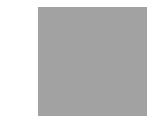

blue, R,G,B: 154 151 153


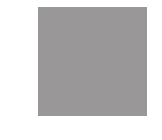

dark blue, R,G,B: 160 154 154


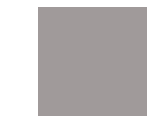

tensorflow orange, R,G,B: 155 159 144


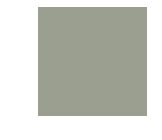

In [0]:
predict("light blue", model_original)
predict("blue", model_original)
predict("dark blue", model_original)
predict("tensorflow orange", model_original)

In [0]:
# just for fun, let us also measure the accuracy
model_original.evaluate(padded_names_test, targets_test)

1416/1416 [==============================] - 0s 30us/sample - loss: 0.0629


0.06293528346018602